In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Show all columns
pd.set_option('display.max_columns', None)

# Load datasets
production = pd.read_csv("production.csv")
area = pd.read_csv("area_harvested.csv")
rainfall = pd.read_csv("rainfall.csv")
fertilizer = pd.read_csv("fertilizer.csv")


In [2]:
# Keep only relevant columns
production = production[['Year', 'Item', 'Value']]
production.rename(columns={'Value': 'Production_Tonnes'}, inplace=True)


In [3]:
area = area[['Year', 'Item', 'Value']]
area.rename(columns={'Value': 'Area_Harvested_ha'}, inplace=True)


In [4]:
# Your rainfall file likely contains a lot of extra dimensions
# We'll keep only YEAR + OBS_VALUE (rainfall in mm)

rainfall = rainfall[['TIME_PERIOD', 'OBS_VALUE']]
rainfall.rename(columns={'TIME_PERIOD': 'Year', 'OBS_VALUE': 'Rainfall_mm'}, inplace=True)

# Convert year to int and drop missing
rainfall['Year'] = rainfall['Year'].astype(int)
rainfall = rainfall[rainfall['Year'].between(2000, 2023)]
rainfall = rainfall.groupby('Year', as_index=False)['Rainfall_mm'].mean().round(1)


In [5]:
# Keep only Year and Value for Nutrient nitrogen
fertilizer = fertilizer[['Year', 'Item', 'Value']]
fertilizer = fertilizer[fertilizer['Item'] == 'Nutrient nitrogen N (total)']
fertilizer = fertilizer[['Year', 'Value']]
fertilizer.rename(columns={'Value': 'Fertilizer_Tonnes'}, inplace=True)

# Convert year to int and drop missing
fertilizer['Year'] = fertilizer['Year'].astype(int)
fertilizer = fertilizer[fertilizer['Fertilizer_Tonnes'].notna()]


In [6]:
# Merge production and area on Year + Crop (Item)
df = pd.merge(production, area, on=['Year', 'Item'])

# Add rainfall (by Year only)
df = pd.merge(df, rainfall, on='Year', how='left')

# Add fertilizer (by Year only)
df = pd.merge(df, fertilizer, on='Year', how='left')

# Drop rows with any remaining NaN
df.dropna(subset=['Production_Tonnes', 'Area_Harvested_ha', 'Rainfall_mm', 'Fertilizer_Tonnes'], inplace=True)

# Final check
df.head()


,Year,Item,Production_Tonnes,Area_Harvested_ha,Rainfall_mm,Fertilizer_Tonnes
0,2000,"Beans, dry",215347.0,333205,1170.9,100
1,2001,"Beans, dry",242157.0,343966,1177.4,100
2,2002,"Beans, dry",246906.0,358002,1177.3,877
3,2003,"Beans, dry",239394.0,356519,1177.4,877
4,2004,"Beans, dry",198224.0,319349,1177.4,709


In [7]:
df.to_csv("cleaned_agriculture_data.csv", index=False)


In [8]:
df.describe()
df['Item'].value_counts()


Item
Beans, dry        22
Cassava, fresh    22
Maize (corn)      22
Rice              22
Sorghum           22
Wheat             22
Name: count, dtype: int64

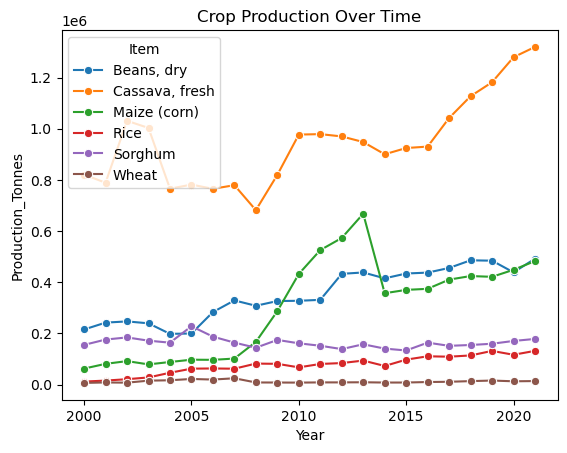

In [9]:
sns.lineplot(data=df, x="Year", y="Production_Tonnes", hue="Item", marker='o')
plt.title("Crop Production Over Time")
plt.show()


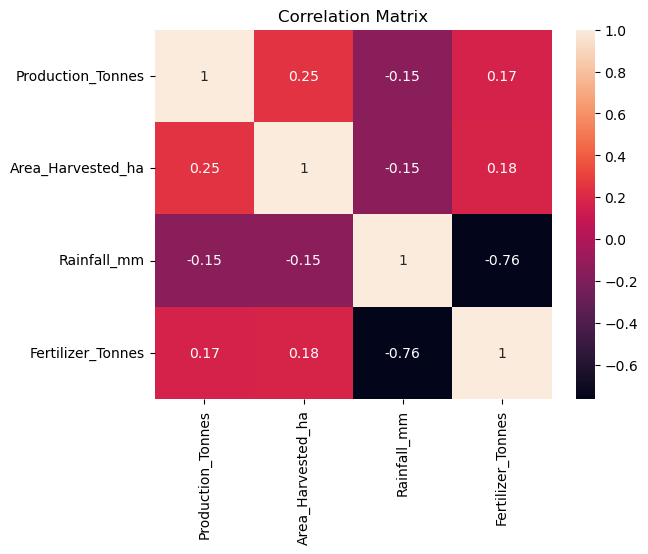

In [10]:
sns.heatmap(df[['Production_Tonnes', 'Area_Harvested_ha', 'Rainfall_mm', 'Fertilizer_Tonnes']].corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()


In [23]:
X = df[['Rainfall_mm', 'Fertilizer_Tonnes', 'Area_Harvested_ha']]
y = df['Production_Tonnes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [27]:
y_pred = model.predict(X_test)

print("R² score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

# Coefficients
pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})


R² score: -0.04985222055155103
Mean Squared Error: 126087112727.65837


,Feature,Coefficient
0,Rainfall_mm,-8998.121702
1,Fertilizer_Tonnes,2.779409
2,Area_Harvested_ha,0.507589


In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [31]:
# Predict on test data
y_pred = model.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Display results
print(f"R² Score: {r2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


R² Score: -0.05
Root Mean Squared Error (RMSE): 355087.47
Mean Absolute Error (MAE): 251451.58


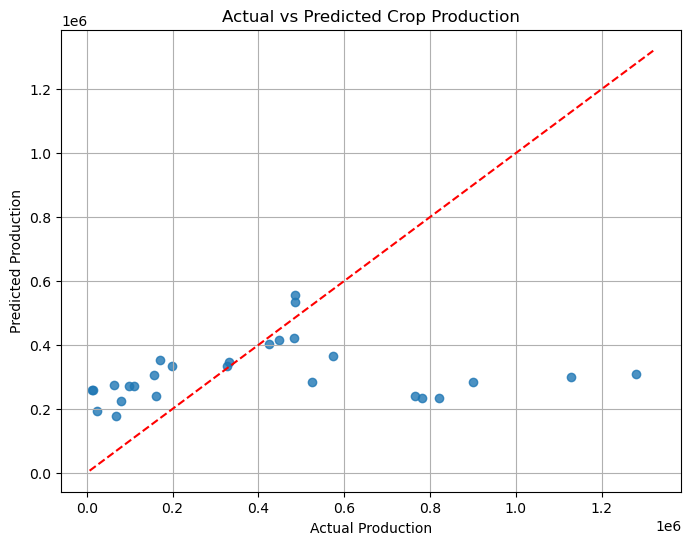

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.8)
plt.xlabel("Actual Production")
plt.ylabel("Predicted Production")
plt.title("Actual vs Predicted Crop Production")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # ideal prediction line
plt.grid(True)
plt.show()


In [35]:
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"R² Score: {r2:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")


In [37]:
evaluate_model(y_test, y_pred)


R² Score: -0.05
RMSE: 355087.47
MAE: 251451.58


In [39]:
# Save your final cleaned dataframe as CSV
df.to_csv("cleaned_agriculture_data.csv", index=False)


In [45]:
df.to_csv("cleaned_agriculture_data.csv", index=False, encoding='utf-8')


In [49]:
y_pred = model.predict(X_test)


In [51]:
# Create a DataFrame for comparison
predictions_df = pd.DataFrame({
    'Year': X_test['Year'] if 'Year' in X_test.columns else df.loc[X_test.index, 'Year'],
    'Crop': df.loc[X_test.index, 'Item'],  # Get crop names
    'Actual_Production': y_test,
    'Predicted_Production': y_pred
})


In [53]:
# Optional rounding
predictions_df['Actual_Production'] = predictions_df['Actual_Production'].round(2)
predictions_df['Predicted_Production'] = predictions_df['Predicted_Production'].round(2)


In [55]:
predictions_df.to_csv("predicted_vs_actual.csv", index=False)


In [57]:
import pandas as pd

# Future years
years = list(range(2022, 2028))  # 2022 to 2027 inclusive

# Crops to predict
crops = ['Maize (corn)', 'Beans, dry']

# Assumed input values (adjust as needed)
future_inputs = {
    'Maize (corn)': {
        'Rainfall_mm': [1150, 1160, 1140, 1170, 1180, 1190],
        'Fertilizer_Tonnes': [1000, 1050, 1100, 1120, 1150, 1175],
        'Area_Harvested_ha': [350000, 360000, 370000, 380000, 390000, 400000]
    },
    'Beans, dry': {
        'Rainfall_mm': [1145, 1130, 1155, 1165, 1170, 1185],
        'Fertilizer_Tonnes': [940, 960, 980, 1000, 1020, 1040],
        'Area_Harvested_ha': [600000, 610000, 620000, 630000, 640000, 650000]
    }
}

# Predict for all combinations
all_predictions = []

for crop in crops:
    for i, year in enumerate(years):
        # Create input for model
        input_data = pd.DataFrame({
            'Rainfall_mm': [future_inputs[crop]['Rainfall_mm'][i]],
            'Fertilizer_Tonnes': [future_inputs[crop]['Fertilizer_Tonnes'][i]],
            'Area_Harvested_ha': [future_inputs[crop]['Area_Harvested_ha'][i]]
        })

        # Predict using your trained model
        prediction = model.predict(input_data)[0]

        # Save results
        all_predictions.append({
            'Year': year,
            'Item': crop,
            'Rainfall_mm': input_data['Rainfall_mm'][0],
            'Fertilizer_Tonnes': input_data['Fertilizer_Tonnes'][0],
            'Area_Harvested_ha': input_data['Area_Harvested_ha'][0],
            'Predicted_Production': round(prediction, 2)
        })

# Convert to DataFrame
predicted_df = pd.DataFrame(all_predictions)

# Save as CSV for Power BI
predicted_df.to_csv("predicted_production_2022_2027.csv", index=False)

# Preview
print(predicted_df)


    Year          Item  Rainfall_mm  Fertilizer_Tonnes  Area_Harvested_ha  \
0   2022  Maize (corn)         1150               1000             350000   
1   2023  Maize (corn)         1160               1050             360000   
2   2024  Maize (corn)         1140               1100             370000   
3   2025  Maize (corn)         1170               1120             380000   
4   2026  Maize (corn)         1180               1150             390000   
5   2027  Maize (corn)         1190               1175             400000   
6   2022    Beans, dry         1145                940             600000   
7   2023    Beans, dry         1130                960             610000   
8   2024    Beans, dry         1155                980             620000   
9   2025    Beans, dry         1165               1000             630000   
10  2026    Beans, dry         1170               1020             640000   
11  2027    Beans, dry         1185               1040             650000   